In [37]:
import pandas as pd
import numpy as np
import anndata as an
import os
import sys
import scipy
import gget

import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
bj = pd.read_csv("../resources/Fibroblast_BJ_20210505_AC.csv")
print(f"{bj.shape=}")
bj.columns = ['gene_name', 'tpm']
bj = bj.sort_values(by='tpm', ascending=False)

# exlude certain classes of genes
bj = bj[~bj['gene_name'].str.startswith("RP")]
bj = bj[~bj['gene_name'].str.startswith("MT")]

bj.head()

bj.shape=(19379, 2)


,gene_name,tpm
17188,TMSB10,45584.16
14333,S100A6,35129.31
8725,LGALS1,22412.13
17191,TMSB4X,15365.34
10196,MYL6,14625.02


In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/clustered.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 8562 × 14972
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id'
    uns: 'clusters', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [17]:
# extract the gene expression values
data = adata.to_df()
data.columns = adata.var['gene_name'].values

gene_sum = data.sum(axis=0).reset_index()
gene_sum.columns = ['gene_name', 'tpm_sc']
gene_sum

,gene_name,tpm_sc
0,ATAD3B,507.801575
1,SKI,2130.166992
2,PEX14,369.196228
3,PLCH2,258.160431
4,SPSB1,3.908792
...,...,...
14967,CDY2B,3.546597
14968,SRY,28.416355
14969,VCY,10514.135742
14970,DAZ1,6.367323


In [23]:
def min_max(v):
    return (v - v.min()) / (v.max() - v.min())

df = pd.merge(bj, gene_sum,
              how='inner',
              left_on='gene_name',
              right_on='gene_name',
             )

print(f"{df.shape=}")
df['pop_norm'] = min_max(df['tpm'])
df['sc_norm'] = min_max(df['tpm_sc'])
df['diff'] = df['sc_norm'] - df['pop_norm']

df = df.sort_values(by='diff')

df.head()

df.shape=(14684, 3)


,gene_name,tpm,tpm_sc,pop_norm,sc_norm,diff
0,TMSB10,45584.16,308.120911,1.000000,0.006134,-0.993866
1,S100A6,35129.31,703.487915,0.770647,0.014043,-0.756605
2,MYL6,14625.02,3828.085205,0.320836,0.076549,-0.244287
4,ATP5ME,8039.96,760.609802,0.176376,0.015185,-0.161191
3,S100A4,8394.92,1749.693970,0.184163,0.034972,-0.149191


In [24]:
df[['pop_norm', 'sc_norm']].corr()

,pop_norm,sc_norm
pop_norm,1.000000,-0.002296
sc_norm,-0.002296,1.000000


In [25]:
df.tail()

,gene_name,tpm,tpm_sc,pop_norm,sc_norm,diff
7075,TMEM168,0.73,40539.296875,0.000016,0.810940,0.810924
977,ATG12,36.02,40887.523438,0.000790,0.817906,0.817116
4750,PSEN2,2.41,41292.425781,0.000053,0.826006,0.825953
8097,MINDY1,0.38,41907.191406,0.000008,0.838304,0.838296
10623,CEACAM3,0.00,49990.152344,0.000000,1.000000,1.000000


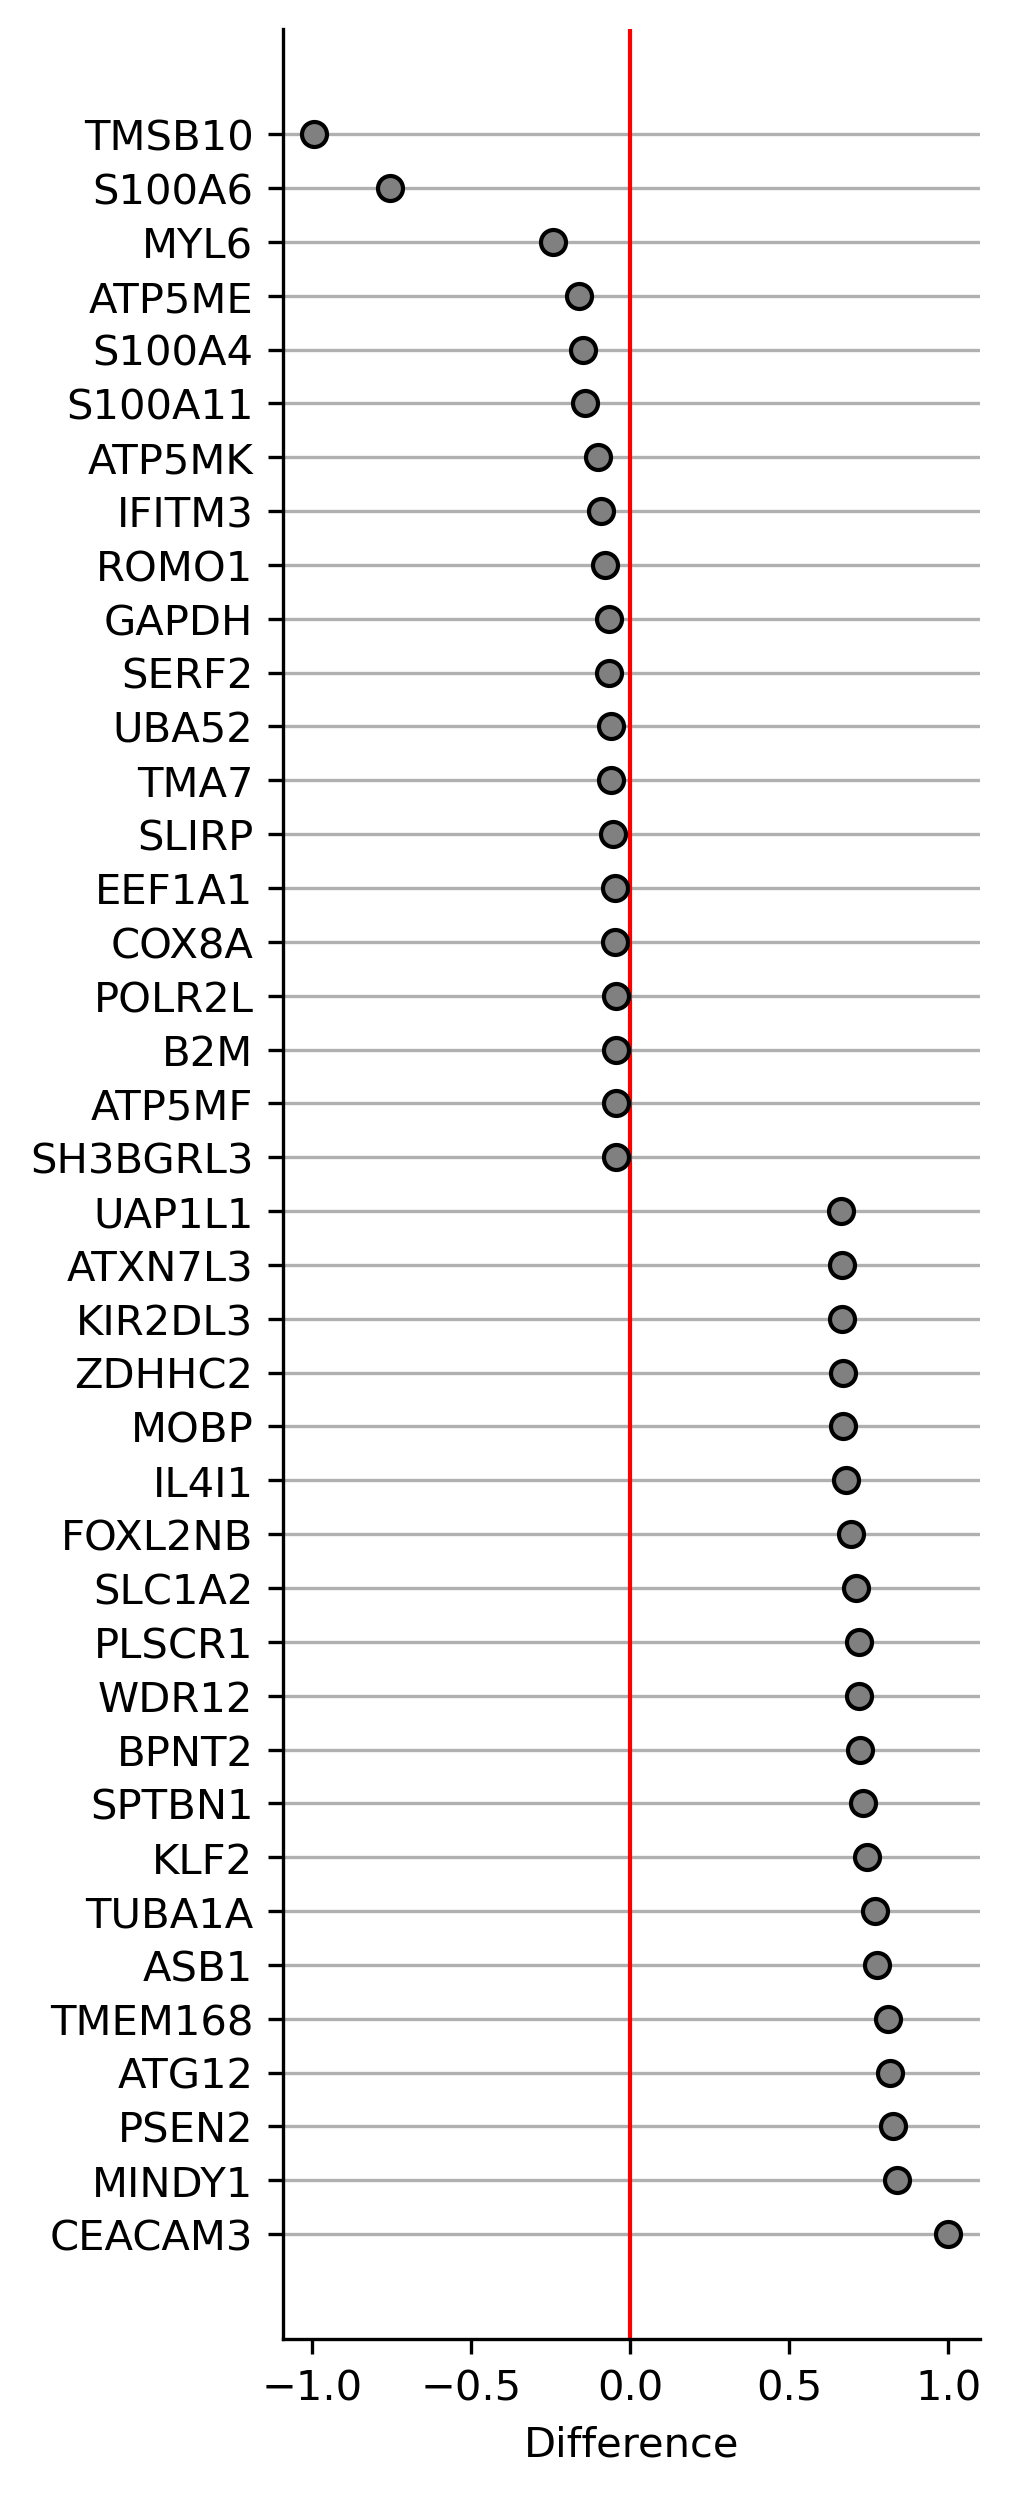

In [48]:
n = 20
to_plot = pd.concat([df.head(n), df.tail(n)])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 10
sns.scatterplot(data=to_plot, 
                y='gene_name',
                x='diff',
                ec='k',
                lw=1,
                zorder=3,
                color='grey')

plt.axvline(x=0, lw=1, c='r', zorder=2,)
plt.grid(True, axis='y', zorder=0)
# plt.xticks([])
plt.ylabel("")
plt.xlabel("Difference")
sns.despine()

In [62]:
tf_path = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/processed_data/500bp_up_100bp_down_B.csv"
tf = pd.read_csv(tf_path)
tf = tf.rename(columns={"Unnamed: 0" : 'gene_name'})
tf = tf.set_index('gene_name')

tf_list = tf.columns

tf.head()

,ABL1,ACAA1,ADNP,ADNP2,AEBP2,AFF4,AHCTF1,AHDC1,AHR,AHRR,...,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSCAN5C,ZSCAN9,ZXDA,ZXDB,ZXDC,ZZZ3
gene_name,,,,,,,,,,,,,,,,,,,,,
A1BG,1.65,0.0,5.060,0.0,0.0,8.470,6.400,2.290,0.83060,0.0,...,0.0,0.0,0.0,0.0,1.32,1.448,1.790,1.484333,0.0,1.37
A1BG-AS1,0.00,0.0,0.545,0.0,0.0,0.379,0.000,0.000,0.14640,0.0,...,0.0,0.0,0.0,0.0,0.00,0.770,1.465,1.032333,0.0,0.00
A1CF,1.55,0.0,0.000,0.0,0.0,3.780,4.880,1.092,0.31400,0.0,...,0.0,0.0,0.0,0.0,0.00,0.920,2.865,1.910000,0.0,2.67
A2M,1.39,0.0,0.827,0.0,0.0,4.700,0.810,1.055,0.27314,0.0,...,0.0,0.0,0.0,0.0,0.00,0.535,0.885,0.698000,0.0,3.45
A2M-AS1,0.00,0.0,0.000,0.0,0.0,1.450,0.111,0.000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.00,0.800,0.000,0.059333,0.0,0.00


In [64]:
df['is_TF'] = df['gene_name'].isin(tf_list)
df.head()

,gene_name,tpm,tpm_sc,pop_norm,sc_norm,diff,is_TF
0,TMSB10,45584.16,308.120911,1.000000,0.006134,-0.993866,False
1,S100A6,35129.31,703.487915,0.770647,0.014043,-0.756605,False
2,MYL6,14625.02,3828.085205,0.320836,0.076549,-0.244287,False
4,ATP5ME,8039.96,760.609802,0.176376,0.015185,-0.161191,False
3,S100A4,8394.92,1749.693970,0.184163,0.034972,-0.149191,False


In [77]:
df[df['is_TF']].tail(50)

,gene_name,tpm,tpm_sc,pop_norm,sc_norm,diff,is_TF
11680,ZBED6,0.00,6256.032227,0.000000e+00,0.125119,0.125119,True
10269,ZNF615,0.02,6321.956055,4.387489e-07,0.126438,0.126437,True
7887,ZSCAN29,0.43,6372.298340,9.433101e-06,0.127445,0.127435,True
1751,UBE2K,14.90,6937.097168,3.268679e-04,0.138743,0.138416,True
9119,HES6,0.15,7046.089844,3.290617e-06,0.140924,0.140920,True
2721,DEAF1,7.37,7096.969727,1.616790e-04,0.141941,0.141780,True
10309,NR6A1,0.02,7284.867676,4.387489e-07,0.145700,0.145700,True
4109,ATF6,3.30,7371.213379,7.239357e-05,0.147428,0.147355,True
9558,NR4A2,0.09,7386.364746,1.974370e-06,0.147731,0.147729,True
10891,EMX1,0.00,7618.178223,0.000000e+00,0.152368,0.152368,True


In [76]:
# top n enrichraaa

n = 25
database = 'WikiPathway_2023_Human'
genes = df[df['is_TF']].tail(30)['gene_name'].to_list()

edf = gget.enrichr(genes, database=database)

for idx, row in edf.head(10).iterrows():
    print(f"{row['adj_p_val']=:.3f} {row['path_name']}")


Mon May 20 16:50:45 2024 INFO Performing Enichr analysis using database WikiPathway_2023_Human.


row['adj_p_val']=0.004 Heart Development WP1591
row['adj_p_val']=0.062 Brain Derived Neurotrophic Factor BDNF Signaling Pathway WP2380
row['adj_p_val']=0.074 Genes Controlling Nephrogenesis WP4823
row['adj_p_val']=0.075 IL 18 Signaling Pathway WP4754
row['adj_p_val']=0.075 Markers Of Kidney Cell Lineage WP5236
row['adj_p_val']=0.075 Vitamins A And D Action Mechanisms WP4342
row['adj_p_val']=0.075 Primary Focal Segmental Glomerulosclerosis FSGS WP2572
row['adj_p_val']=0.075 Head And Neck Squamous Cell Carcinoma WP4674
row['adj_p_val']=0.085 MicroRNAs In Cardiomyocyte Hypertrophy WP1544
row['adj_p_val']=0.098 EV Release From Cardiac Cells And Their Functional Effects WP3297
